# **Лабораторная работа №4**

*Параллельный алгоритм размытия изображения на CUDA*

**Постановка задачи:** размыть изображение с применением фильтра Гаусса с использованием средств распараллеливания CUDA. 

Общее описание алгоритма: дано изображение NxM, как известно изображение может быть представлен в формате RGB, где каждый пиксель представлен числами от 0 до 255. Требуется создать фильтра размытия, представленный в виде свёрточной матрицы заполненной в соответствии с Гауссовским распределением в двумере (сигму можно сделать параметром), от размера матрицы зависит степень размытия, для теста использовалась матрица 3x3. Можно так же сделать это параметром и поэкспериментировать с различными размерностями. Можно использовать уже известные матрицы свёртки. Затем данный фильтр применяется для каждого пикселя исходного изображения, результат суммируется и записывается в пиксель выходного массива. 

Для работы с краями можно почитать тут https://habr.com/ru/post/142818/, там же есть вполне подробное описание алгоритма и даны примеры свёрточных матриц. В результате все три канала формируют изображение. Можно воспользоваться любой библиотекой для этого (во вложении питоновский ноутбук преобразования изображения в RGB, можете его переписать под нормальный вывод RGB массивов). CUDA достаточно использовать для непосредственно размытия изображения, для предпроцессинга и постпроцессинга RGB каналов ниже описаны специальные функции.

Альтернатива: для тех кому совсем не хочется разбираться с изображениями, можно реализовать алгоритм свёртки матрицы и протестировать его на CUDA для различных размерностей, оценка за это будет соответственно ниже

Содержание отчёта: сравнить время работы алгоритма свёртки или полного метода размытия для различных размерностей матрицы\картинки с CUDA и без, привести пример размытого изображения. Для тестов можно использовать приложенные матрицы и изображения, размытое изображение было получено не программно, так что возможно не точное совпадение при проверке. **Отчет и программу следует писать в этом ноутбуке.** По результату запуска всех секций в ноутбуке, должны выводиться полученные картинки и графики. Если Вам необходимо отправить вместе с ноутбуком дополнительные файлы - отправить их архивом вместе с этим ноутбуком.

Критерии оценивания: 
* 4 балла – алгоритм свёртки для матрицы
* 4 балла – полный метод размытия
* 2 балла – отчёт



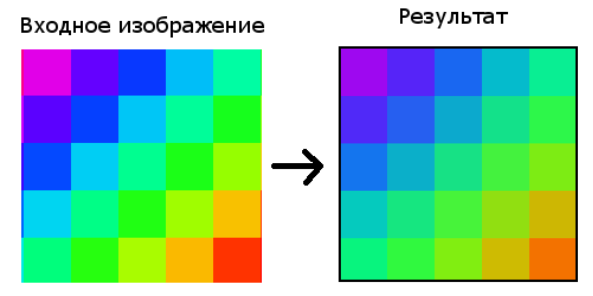

Функция get_RGB(from,to) переводит изображение from в текстовый файл в следующем формате: в первой строке длина и ширина картинки в пикселях. В последующих строчках идут три матрицы для красного, зеленого и синего цвета соотвествующего размера.

Функция read_image(from,to) переводит файл в формате, который описан выше, в RGB изображение.

In [16]:
from PIL import Image
import numpy as np
def get_RGB(image,text):
    img = Image.open(image)
    rgbimg = img.convert('RGB')
    A = []
    for i in range(np.shape(rgbimg)[0]):
        for j in range(np.shape(rgbimg)[1]):
            A.append(rgbimg.getpixel((j,i)))
    A = np.array(A)
    file1 = open(text,"w")
    file1.write(str(np.shape(rgbimg)[0]) + " " + str(np.shape(rgbimg)[1]) + "\n")
    for i in range(3):
        B = A[:, i].reshape(np.shape(rgbimg)[0], np.shape(rgbimg)[1])
        for k in range(B.shape[0]):
            for l in range(B.shape[1]):
                file1.write(str(B[k,l]) + " ");
            file1.write("\n")
    file1.close()
    
def read_image(text,image):
    file = open(text,"r")
    w,h = map(int,file.readline().split())
    A = []
    for i in range(3):
        B = []
        for k in range(w):
            B.append(list(map(np.uint8,file.readline().split())))
        A.append(B)
    A = np.array(A)
    A = A.transpose(1,2,0)
    file.close()
    new_im = Image.fromarray(A,'RGB')
    new_im.save(image)

Для того, чтобы размыть изображение, понадобится матрица свертки. Код ниже создает матрицу 3 на 3 в соответствии с Гауссовским распределением в двумере.

In [23]:
get_RGB('my.tiff', 'my.txt')

In [24]:
read_image('my.txt', 'my_same.tiff')

In [22]:
read_image('my.out', 'my_converted2.tiff')

### Описание того что получилось

Все описал в файле `src/main.cu` все остальное не нужно

Для запуска нужно три аргумента:
1. Путь до файла, из которого читать картинку (в виде чиселок)
2. "cuda"/"cpu" - как считать
3. Нечетное исло - размер матрицы для свертки

##### Как запустить?
Под рукой было два девайса один с видеокартой, другой мак

На ноуте с видеокартой была винда....

В общем собирал и запускал с помощью msbuild (в папке есть скрипт runner.py ок как раз все запускает и строит графики, но если что можно закомментировать строчки 109-110, раскомментировать 111 и поставить туда имя собранной программы)

##### Что еще нужно знать?
У меня первый запуск чего то с CUDA долго раздупляется поэтому запускаю по 10 раз чтобы посчитать среднее!

##### Теперь исследования
В папочке лежат файлики с перфиксом image_ и расширением tiff

На размере 8к запустить не получилось (PIL умер, переписывать на что-то другое не захотел)

Графики будут ниже - ускорение хорошее!

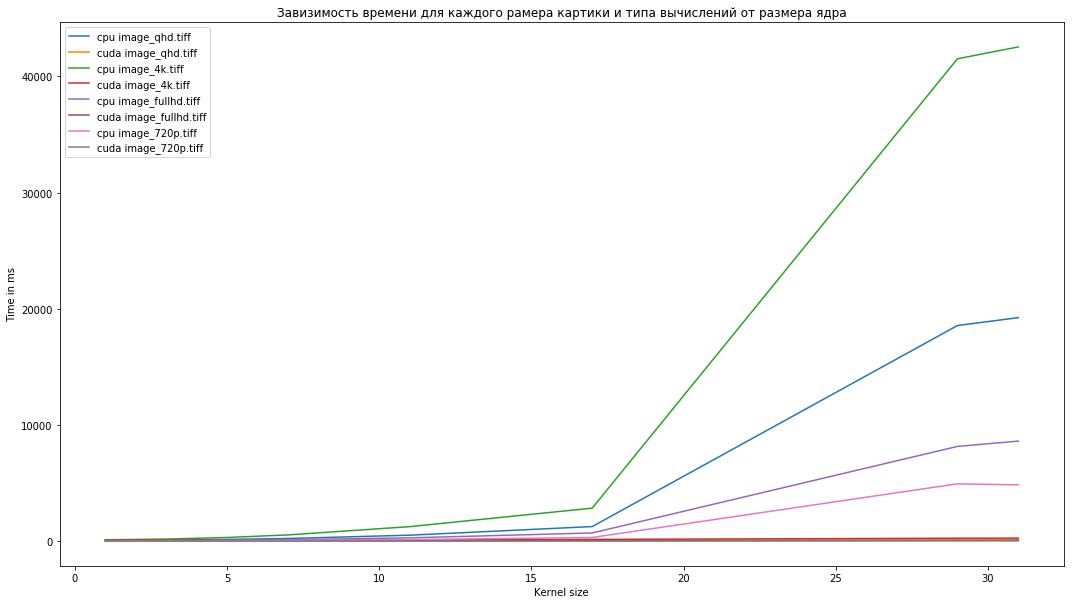

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import json

sizes = [1, 3, 5, 7, 11, 17, 29, 31]

with open('graphs.json', 'r') as inp:
    values = json.loads(inp.read())
    plt.figure(figsize=(18, 10))
    for label in values:
        plt.plot(sizes, values[label], label=label)
    plt.legend()
    plt.title('Завизимость времени для каждого рамера картики и типа вычислений от размера ядра')
    plt.xlabel('Kernel size')
    plt.ylabel('Time in ms')
    plt.show()

#### Не видно что там у CUDA - слишком быстро, поэтому похожий график для только куда и только CPU расчетов

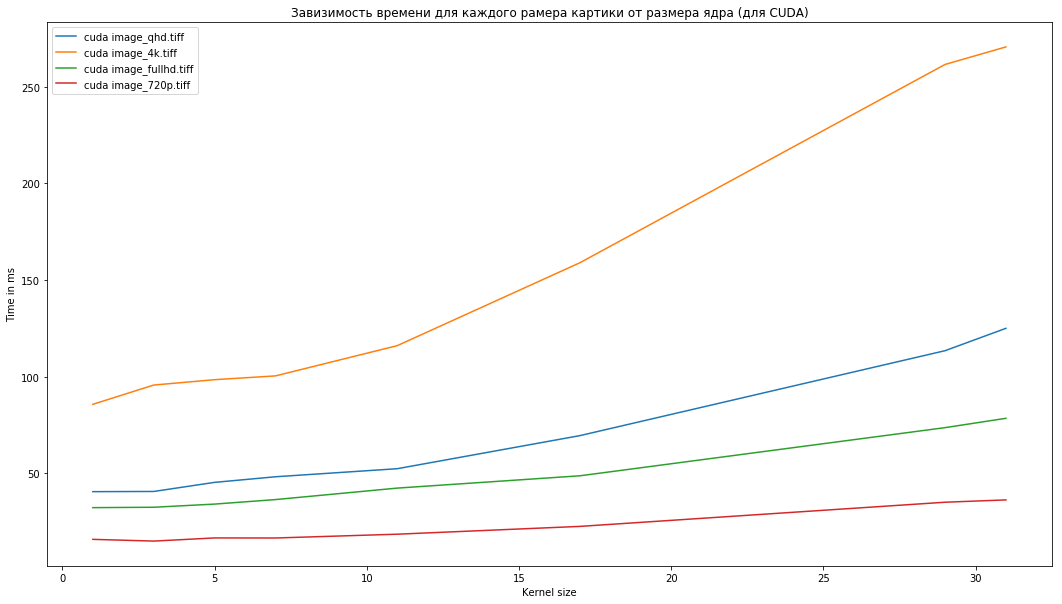

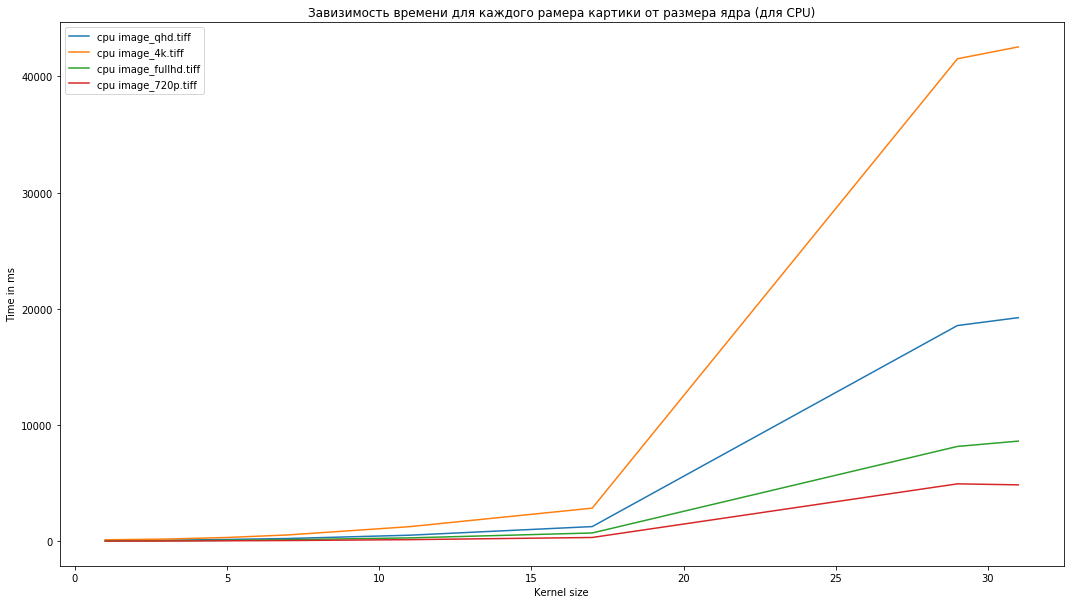

In [9]:
with open('graphs.json', 'r') as inp:
    values = json.loads(inp.read())
    plt.figure(figsize=(18, 10))
    for label in values:
        if label[0:4] == 'cuda':
            plt.plot(sizes, values[label], label=label)
    plt.legend()
    plt.title('Завизимость времени для каждого рамера картики от размера ядра (для CUDA)')
    plt.xlabel('Kernel size')
    plt.ylabel('Time in ms')
    plt.show()
with open('graphs.json', 'r') as inp:
    values = json.loads(inp.read())
    plt.figure(figsize=(18, 10))
    for label in values:
        if label[0:3] == 'cpu':
            plt.plot(sizes, values[label], label=label)
    plt.legend()
    plt.title('Завизимость времени для каждого рамера картики от размера ядра (для CPU)')
    plt.xlabel('Kernel size')
    plt.ylabel('Time in ms')
    plt.show()

#### Теперь еще посмотрим на бар чарты для каждой картинки и размера ядра - 11

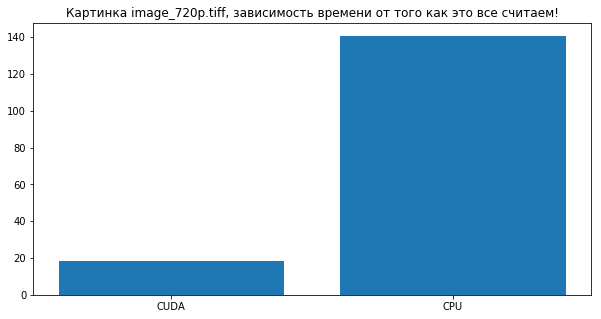

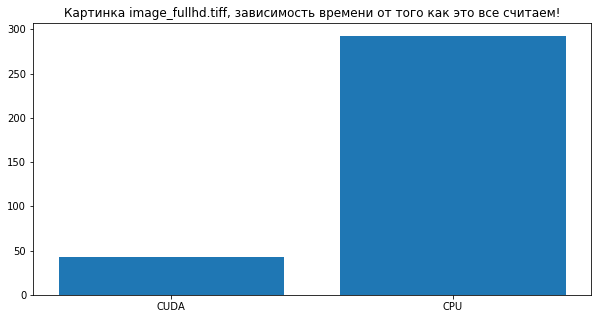

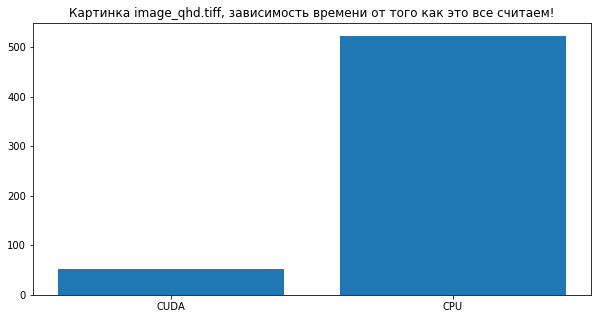

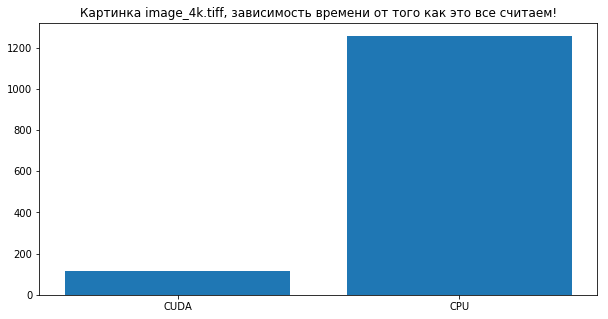

In [16]:
images = ['image_720p.tiff', 'image_fullhd.tiff', 'image_qhd.tiff', 'image_4k.tiff']
for image in images:
    cuda_time = values['cuda ' + image][4]
    cpu_time = values['cpu ' + image][4]
    plt.figure(figsize=(10, 5))
    plt.bar([0, 1], [cuda_time, cpu_time], tick_label=['CUDA', 'CPU'])
    plt.title('Картинка ' + image + ', зависимость времени от того как это все считаем!')
    plt.show()

#### Теперь посмотрим на картинки и что получилось

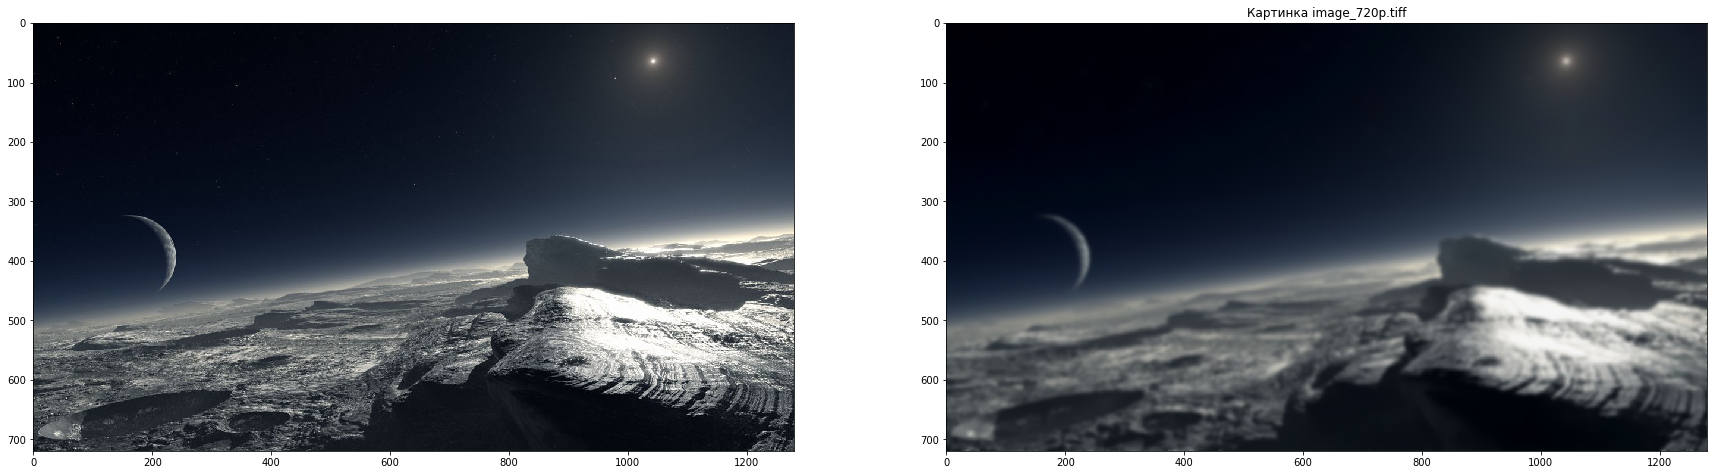

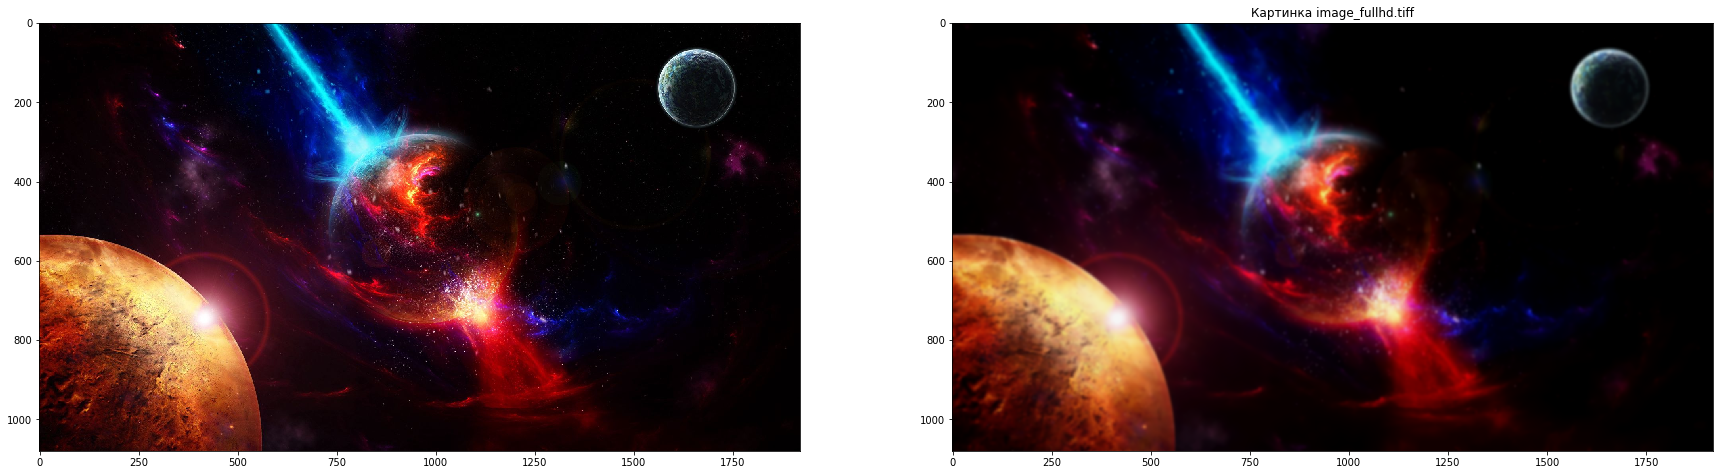

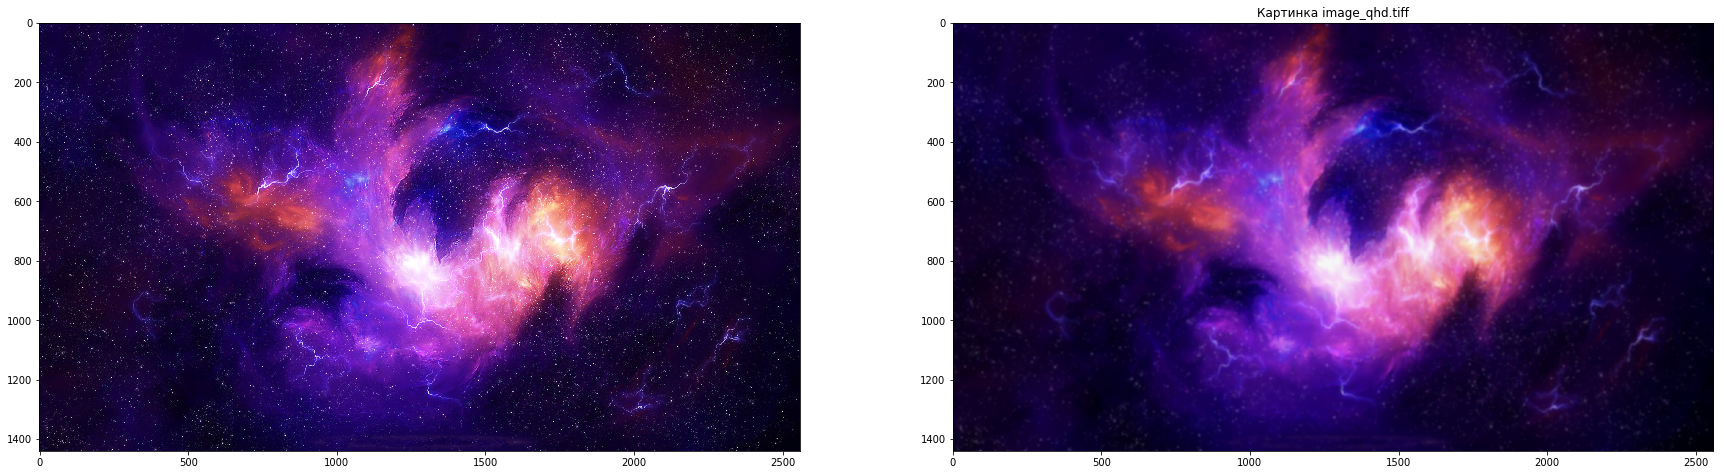

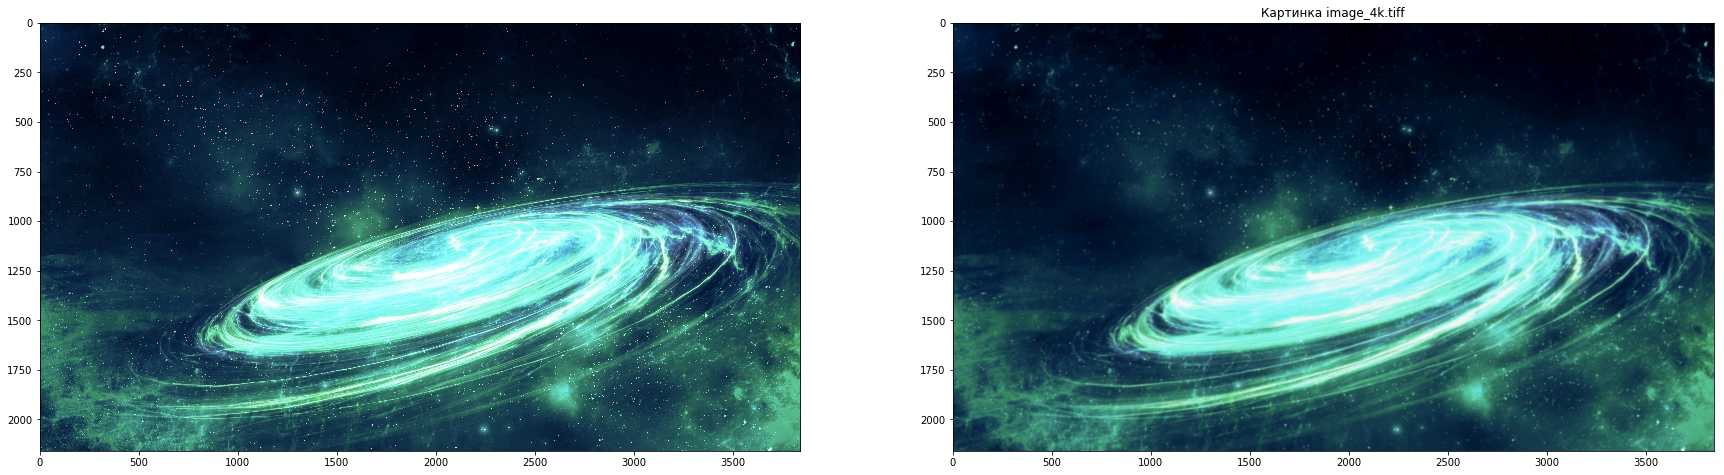

In [42]:
from PIL import Image

for image in images:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    plt.title('Картинка ' + image)
    ax1.imshow(Image.open(image))
    ax2.imshow(Image.open(image.split('.')[0] + '_result.tiff'))
    plt.show()

Подключаем CUDA (не забудьте сменить среду выполнения на GPU): 

In [45]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to c:\users\memlo\appdata\local\temp\pip-req-build-zgcnpe3z
  Running setup.py install for NVCCPlugin: started
    Running setup.py install for NVCCPlugin: finished with status 'error'


  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git 'C:\Users\memlo\AppData\Local\Temp\pip-req-build-zgcnpe3z'
    ERROR: Complete output from command 'c:\program files\python3\python.exe' -u -c 'import setuptools, tokenize;__file__='"'"'C:\\Users\\memlo\\AppData\\Local\\Temp\\pip-req-build-zgcnpe3z\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\memlo\AppData\Local\Temp\pip-record-6fxjdplc\install-record.txt' --single-version-externally-managed --compile:
    ERROR: running install
    running build
    running build_py
    creating build
    creating build\lib
    copying nvcc_plugin.py -> build\lib
    creating build\lib\v2
    copying v2\__init__.py -> build\lib\v2
    copying v2\v2.py -> build\lib\v2
    creating build\lib\v1
    copying v1\__init__.py -> build\lib\v1
    copying v1\v1.py -> build\lib\

In [48]:
%load_ext nvcc_plugin

directory C:\Users\memlo\Desktop\cpp\cpp_simple\src already exists
Out bin C:\Users\memlo\Desktop\cpp\cpp_simple\result.out


In [50]:
%%cu
#include <cstdio>
#include <algorithm>
#include <vector>
#include <cassert>
#include <iostream>
#include <fstream>
#include <chrono>
#include <string>

template <typename T>
class TypeArrayWrapper {
public:
    TypeArrayWrapper(const std::vector<T>& data)
    {
        data_ = new T[data.size()];
        size_ = data.size();
        for (size_t i = 0; i != size_; ++i) {
            data_[i] = data[i];
        }
    }

    TypeArrayWrapper(size_t size, T fill)
    {
        size_ = size;
        data_ = new T[size];
        for (size_t i = 0; i != size; ++i) {
            data_[i] = fill;
        }
    }

    bool isOnDevice() const
    {
        return onDevice_;
    }

    T* deviceData() const
    {
        assert(onDevice_);
        return deviceData_;
    }

    void toDevice()
    {
        assert(!onDevice_);
        initDeviceDataIfNeeded();
        cudaMemcpy(deviceData_, data_, size_ * sizeof(T), cudaMemcpyHostToDevice);
        onDevice_ = true;
    }

    void toHost()
    {
        assert(onDevice_);
        assert(deviceData_);
        cudaMemcpy(data_, deviceData_, size_ * sizeof(T), cudaMemcpyDeviceToHost);
        onDevice_ = false;
    }

    size_t size() const
    {
        return size_;
    }

    T& operator[](size_t index)
    {
        assert(!onDevice_);
        return data_[index];
    }

    std::vector<T> asVector()
    {
        assert(!onDevice_);
        std::vector<T> result;
        result.resize(size_);
        for (size_t i = 0; i != size_; ++i) {
            result[i] = data_[i];
        }
        return result;
    }

    void clear()
    {
        clearAll();
    }

    ~TypeArrayWrapper()
    {
        clearAll();
    }

private:
    void clearAll()
    {
        if (data_) {
            free(data_);
            data_ = nullptr;
        }
        if (deviceData_) {
            cudaFree(deviceData_);
            deviceData_ = nullptr;
        }
    }

    void initDeviceDataIfNeeded()
    {
        if (!deviceData_) {
            cudaMalloc(&deviceData_, size_ * sizeof(T));
        }
    }

    T* data_ = nullptr;
    T* deviceData_ = nullptr;
    size_t size_ = 0;

    bool onDevice_ = false;
};

std::vector<int> addPadding(std::vector<int> pixels, size_t height, size_t width, size_t padding)
{
    const auto coordPrev = [&height, &width](const size_t i, const size_t j) -> size_t {
        return i * width + j;
    };
    const auto coordNew = [&height, &width, &padding](const size_t i, const size_t j) -> size_t {
        return i * (width + padding * 2) + j;
    };

    std::vector<int> result;
    result.resize((height + padding * 2) * (width + padding * 2));
    for (size_t i = 0; i != height + padding * 2; ++i) {
        for (size_t j = 0; j != width + padding * 2; ++j) {
            if (padding <= i && padding <= j && i < height + padding && j < width + padding) {
                result[coordNew(i, j)] = pixels[coordPrev(i - padding, j - padding)];
            } else if (i < padding) {
                size_t coordJ = j < padding
                    ? 0
                    : (j >= width + padding ? width - 1 : j - padding);
                result[coordNew(i, j)] = pixels[coordPrev(0, coordJ)];
            } else if (i >= height + padding) {
                size_t coordJ = j < padding
                    ? 0
                    : (j >= width + padding ? width - 1 : j - padding);
                result[coordNew(i, j)] = pixels[coordPrev(height - 1, coordJ)];
            } else {
                result[coordNew(i, j)] = pixels[coordPrev(i - padding, j < padding ? 0 : width - 1)];
            }
        }
    }
    return result;
}

std::vector<int> removePadding(std::vector<int> pixels, size_t height, size_t width, size_t padding)
{
    const auto coordPrev = [&height, &width](const size_t i, const size_t j) -> size_t {
        return i * width + j;
    };
    const auto coordNew = [&height, &width, &padding](const size_t i, const size_t j) -> size_t {
        return i * (width - padding * 2) + j;
    };

    std::vector<int> result;
    result.resize((height - padding * 2) * (width - padding * 2));
    for (size_t i = 0; i != height; ++i) {
        for (size_t j = 0; j != width; ++j) {
            if (padding <= i && padding <= j && i < height - padding && j < width - padding) {
                result[coordNew(i - padding, j - padding)] = pixels[coordPrev(i, j)];
            }
        }
    }
    return result;
}

std::vector<float> createTransformMatrix(size_t size)
{
    assert(size % 2 == 1);
    int p = size / 2;
    float sigma = 1;
    std::vector<float> result;
    result.reserve(size * size);
    for (int x = -p; x <= p; ++x) {
        for (int y = -p; y <= p; ++y) {
            result.push_back(exp(-(x * x + y * y) / (2 * sigma * sigma)));
        }
    }
    float sum = 0;
    for (const auto& elem : result) {
        sum += elem;
    }
    for (auto& elem : result) {
        elem /= sum;
    }
    return result;
}

__global__ void transform(
    const int height,
    const int width,
    const int maskSize,
    const int* const from,
    int* const to,
    const float* const mask)
{
    const int index = blockIdx.x * blockDim.x + threadIdx.x;
    const int i = index / width;
    const int j = index - i * width;
    if (i < height && j < width) {
        const int pad = maskSize / 2;
        if (pad <= i && pad <= j && i < height - pad && j < width - pad) {
            float sum = 0;
            for (int dx = -pad; dx <= pad; ++dx) {
                for (int dy = -pad; dy <= pad; ++dy) {
                    const int maskIndex = (dx + pad) * maskSize + dy + pad;
                    const int fromIndex = (i + dx) * width + (j + dy);
                    sum += mask[maskIndex] * from[fromIndex];
                }
            }
            to[i * width + j] = sum;
        } else {
            to[i * width + j] = from[i * width + j];
        }
    }
}

std::vector<int> applyTransform(std::vector<int> pixels, size_t height, size_t width, size_t maskSize)
{
    const auto matrix = createTransformMatrix(maskSize);

    TypeArrayWrapper matr(matrix);
    matr.toDevice();

    TypeArrayWrapper data(pixels);
    data.toDevice();

    TypeArrayWrapper<int> result(pixels.size(), 0);
    result.toDevice();

    transform<<<(width * height + 511) / 512, 512>>>(height, width, maskSize, data.deviceData(), result.deviceData(), matr.deviceData());

    result.toHost();
    return result.asVector();
}


std::vector<int> applyTrnasformOnCPU(std::vector<int> pixels, size_t height, size_t width, size_t maskSize)
{
    const auto matrix = createTransformMatrix(maskSize);
    std::vector<int> result;
    result.resize(pixels.size(), 0);

    for (size_t index = 0; index != result.size(); ++index) {
        const int i = index / width;
        const int j = index - i * width;
        if (i < height && j < width) {
            const int pad = maskSize / 2;
            if (pad <= i && pad <= j && i < height - pad && j < width - pad) {
                float sum = 0;
                for (int dx = -pad; dx <= pad; ++dx) {
                    for (int dy = -pad; dy <= pad; ++dy) {
                        const int maskIndex = (dx + pad) * maskSize + dy + pad;
                        const int fromIndex = (i + dx) * width + (j + dy);
                        sum += matrix[maskIndex] * pixels[fromIndex];
                    }
                }
                result[i * width + j] = sum;
            } else {
                result[i * width + j] = pixels[i * width + j];
            }
        }
    }

    return result;
}

class Timer {
public:
    Timer(const std::string& tag)
    : tag_(tag)
    , start_(std::chrono::high_resolution_clock::now())
    {}

    ~Timer()
    {
        const auto diff = std::chrono::duration_cast<std::chrono::milliseconds>(std::chrono::high_resolution_clock::now() - start_).count();
        std::cerr << "[" << tag_ << "] " << diff << std::endl;
    }

private:
    const std::string tag_;
    const std::chrono::steady_clock::time_point start_;
};

int main(int argc, char** argv)
{
//     assert(argc > 3);
    
    const std::string filename = "image_720p.txt";
    std::ifstream fin(filename);

    const std::string mode = "cuda";
    assert(mode == "cuda" || mode == "cpu");

    const std::string kernelSize = 11;
    const size_t kernel = atoi(kernelSize.c_str());
    assert(kernel % 2 == 1);
    const size_t padding = kernel / 2;

    size_t height, width;
    fin >> height >> width;

    std::cout << height << ' ' << width << '\n';

    for (const auto& channel : {0, 1, 2}) {
        std::vector<int> pixels;
        {
            Timer timer("Reading channel " + std::to_string(channel));
            for (size_t i = 0; i != height; ++i) {
                for (size_t j = 0; j != width; ++j) {
                    int value;
                    fin >> value;
                    pixels.push_back(value);
                }
            }
        }
        {
            Timer timer("Adding padding");
            pixels = addPadding(std::move(pixels), height, width, padding);
        }
        for (int i = 0; i != 10; ++i) {
            Timer timer("Transforming");
            if (mode == "cuda") {
                pixels = applyTransform(
                    std::move(pixels),
                    height + padding * 2,
                    width + padding * 2,
                    padding * 2 + 1);
            } else {
                pixels = applyTrnasformOnCPU(
                    std::move(pixels),
                    height + padding * 2,
                    width + padding * 2,
                    padding * 2 + 1);
            }
        }
        {
            Timer timer("Removing padding");
            pixels = removePadding(std::move(pixels), height + padding * 2, width + padding * 2, padding);
        }

        {
            Timer("Writing channel " + std::to_string(channel));
            for (size_t i = 0; i != height; ++i) {
                for (size_t j = 0; j != width; ++j) {
                    std::cout << pixels[i * width + j] << ' ';
                }
                std::cout << '\n';
            }
        }
    }
}


FileNotFoundError: [WinError 2] Не удается найти указанный файл